### Train a Simple Classifier

In our first session we learned about training a classifier on the MNIST Images. The thing about MNIST though is the dataset is very simple! Today we will repeat this, but with a slightly more complex dataset known as CIFAR10. This will also motivate why we love Convolutions later!



In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
print(torch.__version__)


2.6.0


### Lets Explore the Data

We will load the data here, lets take a quick look at what it looks like!

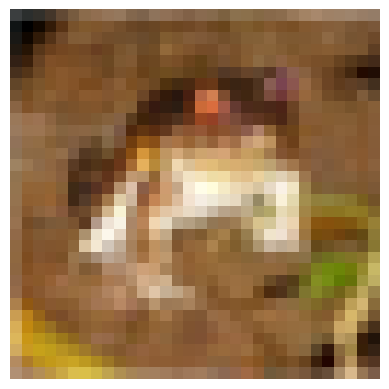

In [27]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

sample, label = next(iter(trainset))

plt.imshow(np.array(sample))
plt.axis("off")
plt.show()

Thats a Frog! Just like MNIST there are 10 classes of images that we need to classify between!

### Define a Model

You can use any model shape you want, just use Linear layers only though. This means you can test how many hidden nodes to have in intermediate layers, and also how many layers you want in total. You can also play with different activation functions to see what works better!

In [28]:
class LinearNN(nn.Module):
    def __init__(self, input_size=32*32*3, num_classes=10):
        super(LinearNN, self).__init__()
        
        # Define the model parts using linear layers
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)        # Second hidden layer
        self.fc3 = nn.Linear(64, num_classes)  # Output layer
        self.relu = nn.ReLU()  # Activation function
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        
        # Pass through the layers with activation
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
model = LinearNN()
model

LinearNN(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

### Define a Dataloader

We Now need to prepare our dataloader with the batch size we want to train with! I provide the datasets here (with some simple image transforms such as converting PIL to tensor and then normalizing). Create the dataloaders from that!

In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

BATCH_SIZE = 64
# shuffle is to randomize the order of the data to avoid overfitting
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


### Train a Model

Train your model for however many epochs you want. Make sure to calculate the average loss and accuracy per epoch for both the training set and evaluation set so we can plot our training curves after!

Things we need to set:

- Device
- Loss Function (what loss do we use for classification?)
- Optimizer (you can use whatever you want, and whatever learning rate you want)

In [ ]:
### Set the Device ###
device = "cuda" if torch.cuda.is_available() else "cpu"

### Set the Loss Function ###
criterion = torch.nn.CrossEntropyLoss() # this is good for multi-class classification


### Load the Model ###
import torchvision.models as models
model = models.resnet18(weights="IMAGENET1K_V1")    # pretrained model

### Set the Optimizer ###
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### Store metrics ###
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

### Training Loop ###
epochs = 10

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients since gradients are accumulated by default
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)  # Forward pass: computes the predictions
        loss = criterion(outputs, labels) # Compute the loss based on the difference between predictions and true labels
        # Backward pass and optimize
        loss.backward() # Backward pass: computes the gradients of the loss w.r.t. the model parameters
        optimizer.step() # Updates the model's parameters using the computed gradients
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)   # Get the predicted class, maximum for the best prediction       
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # Store metrics
    train_loss = running_loss / len(trainloader)
    train_accuracy = 100.0 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    # Training and validation loop
    with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Update metrics
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
    val_loss = val_running_loss / len(testloader)
    val_accuracy = 100.0 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    # Print epoch metrics
    print(f"Epoch {epoch+1}/{epochs}, "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
### WRITE TRAINING LOOP ###
### STORE THE PER EPOCH TRAIN/VAL LOSS/ACC IN THE ## 
### STORE METRICS LIST ABOVE ###



Epoch 1/10, Train Loss: 1.2834, Train Accuracy: 60.81%, Val Loss: 0.7751, Val Accuracy: 73.50%
Epoch 2/10, Train Loss: 0.6823, Train Accuracy: 76.39%, Val Loss: 0.6799, Val Accuracy: 76.92%


### Plot Loss and Accuracy

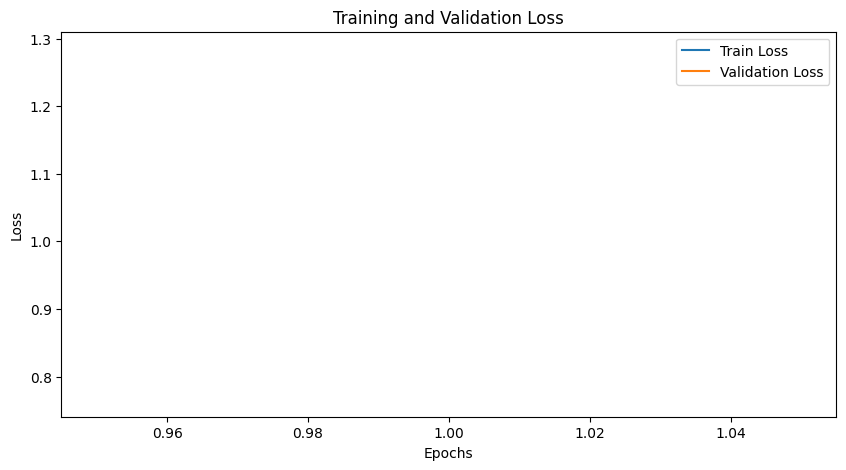

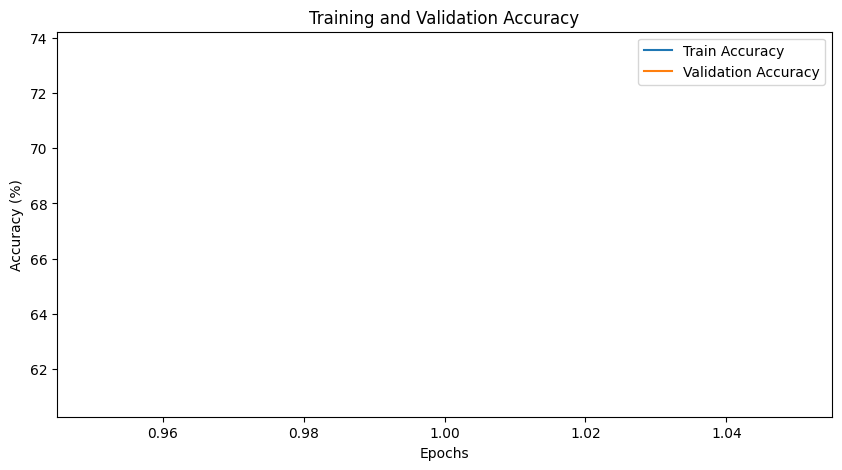

In [35]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()